In [2]:
import numpy as np
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import warnings
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from pandas import Series
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import StandardScaler
from math import sqrt
from datetime import datetime,timedelta
from dateutil.rrule import rrule, HOURLY

warnings.filterwarnings("ignore")

frames=[]
df=[]
stations = []
stations.append(pd.read_csv("stations.csv"))
for i in range(2001,2019):
    df.append(pd.read_csv("csvs_per_year/madrid_"+str(i)+".csv", index_col='date', parse_dates=True))
#    df[len(df)-1].index = pd.to_datetime(df[len(df)-1]['date'])
    df[len(df)-1].sort_index(inplace=True)

    start = df[len(df)-1].index[0]
    end = df[len(df)-1].index[len(df[len(df)-1].index)-1]
    
    flag = True
    missing_start=start
    missing_end=end
    frames.append(df[len(df)-1])
    
dffinal=pd.concat(frames);
dffinal.sort_index(inplace=True)
#print(dffinal.head())

df=dffinal[['NO_2','PM10','PM25','NO','CH4','BEN','CO','EBE','MXY','NMHC','NOx','OXY','O_3','PXY','SO_2','TCH','TOL','station']].groupby(['station']).count()

dfs=df.sort_values(['PM25','NO_2', 'PM10'],ascending=[False,False, False])
print(dfs)


            NO_2    PM10    PM25     NO   CH4     BEN      CO     EBE    MXY  \
station                                                                        
28079024  149782  149058  121807  63585  4911  137910  149779  133762  72331   
28079038  151055  145065  112620  64028     0   71690   78496   70999      0   
28079008  138423  135851   73664  63516  5004  132088  138760  132067      0   
28079047   73077   72779   72420  64055     0       0       0       0      0   
28079050   70720   69636   69054  63763     0       0       0       0      0   
28079048   69009   68012   67512  63876     0       0       0       0      0   
28079099   87571   87576   60291      0     0   87128   87621   87036  81779   
28079026   61317   61236   51156      0     0   41077       0   41080      0   
28079006   74699   74785   50250      0     0   73606   74895   73578  73516   
28079022   77547   77403   49885      0     0   34553   77441       0      0   
28079001   71897   71920   44406      0 

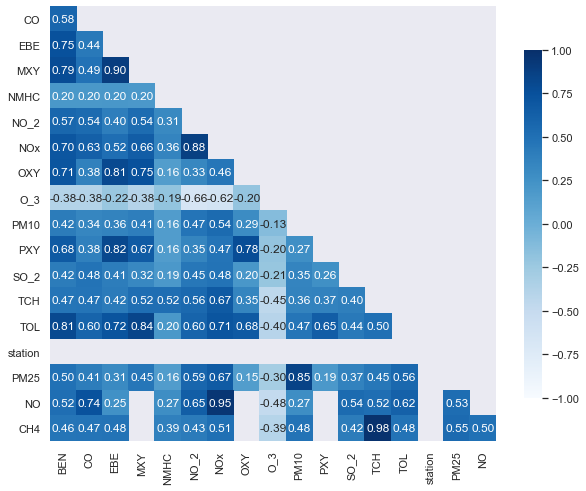

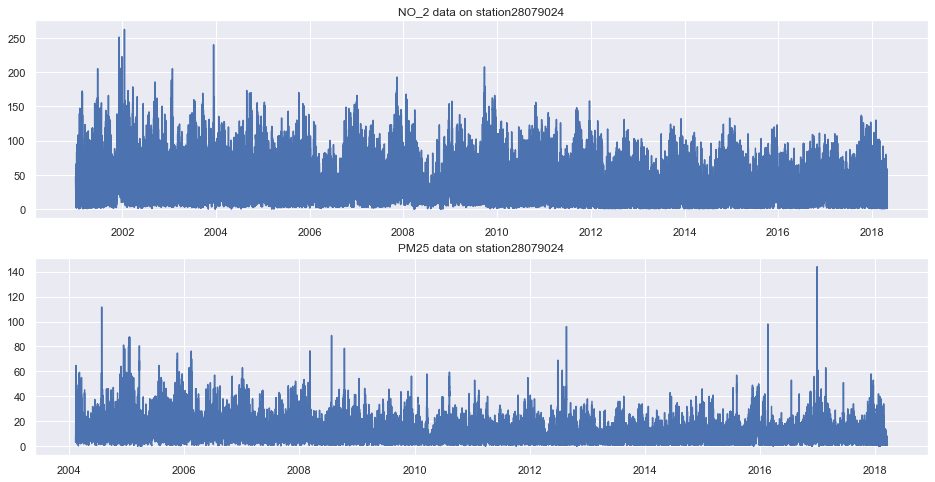

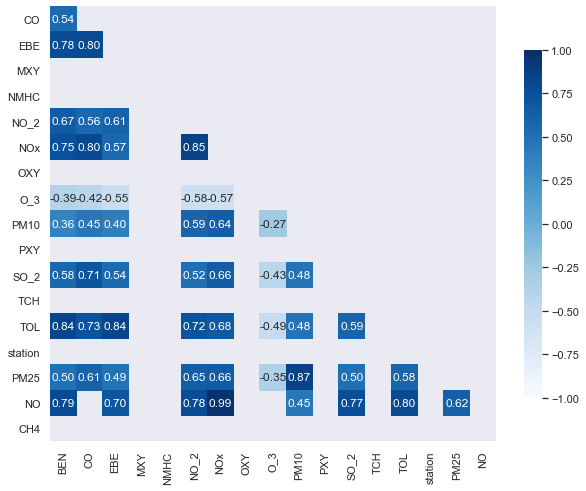

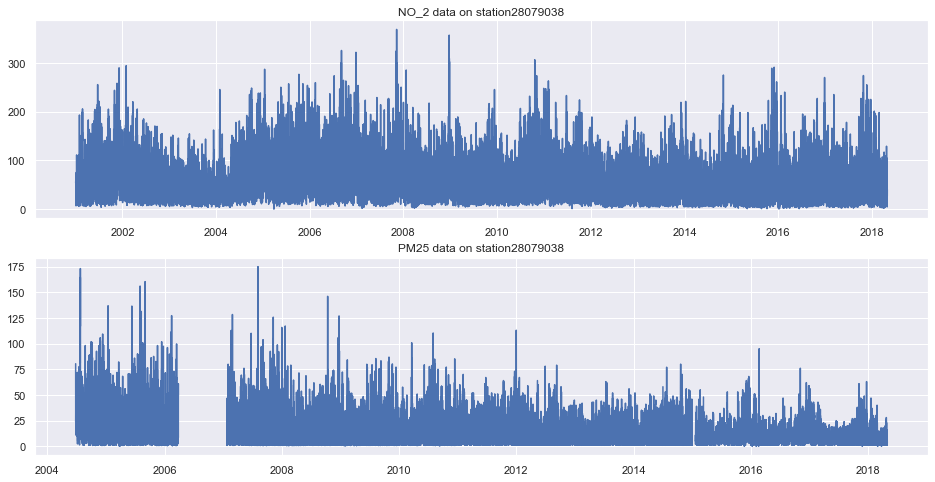

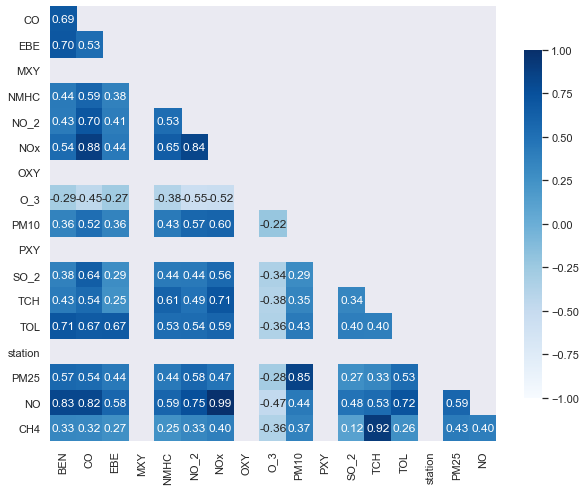

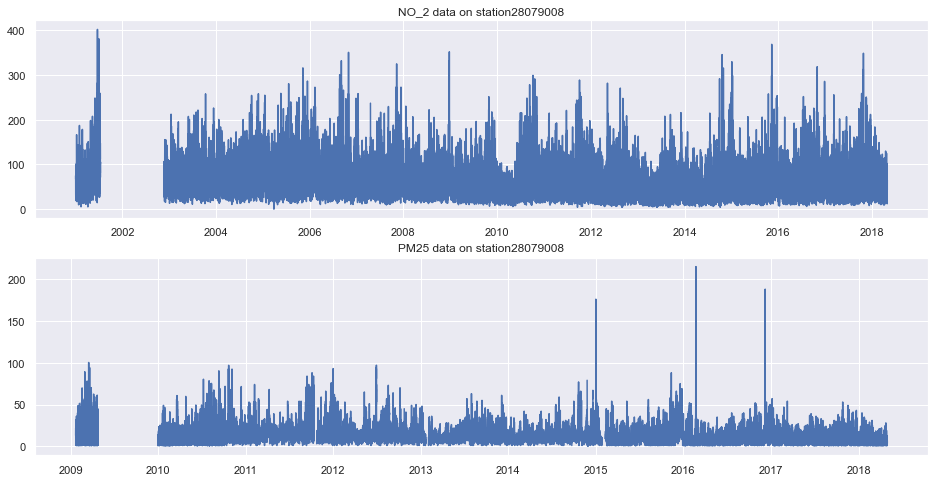

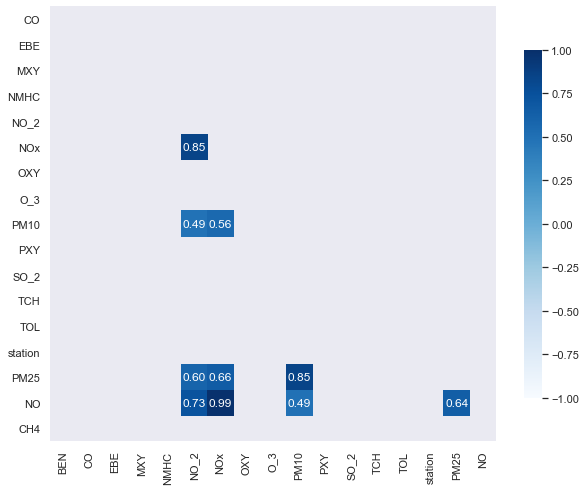

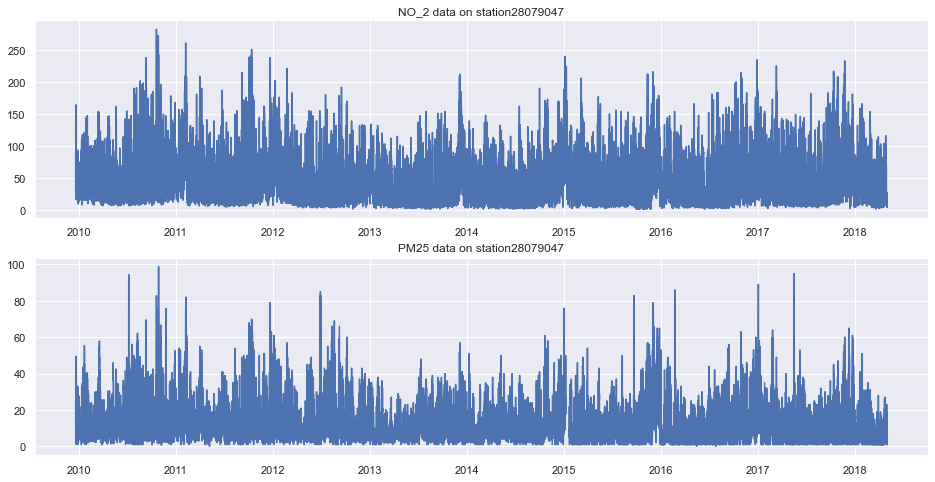

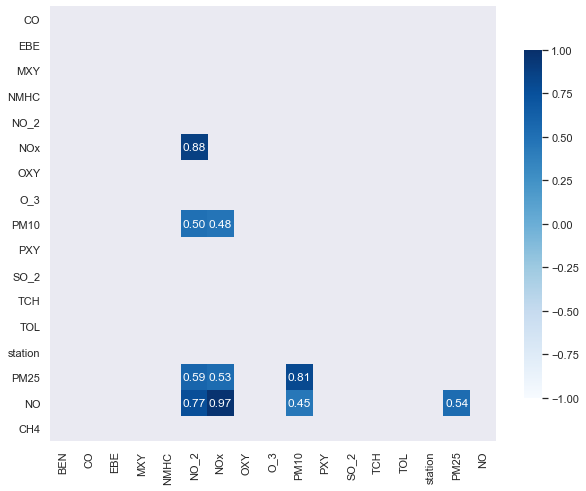

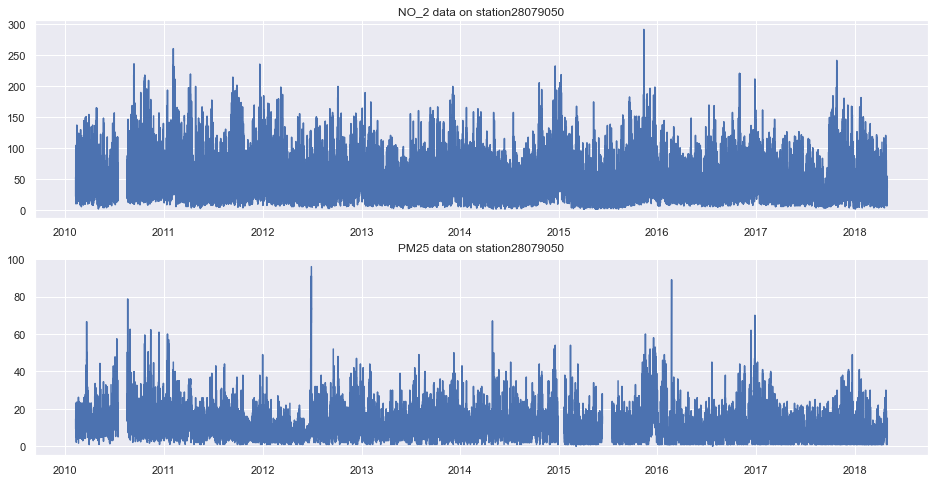

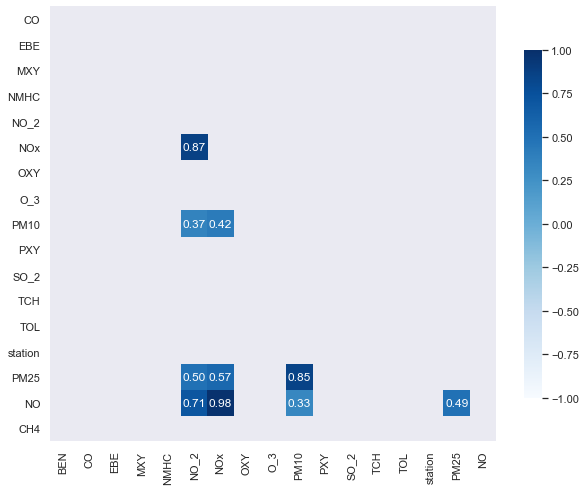

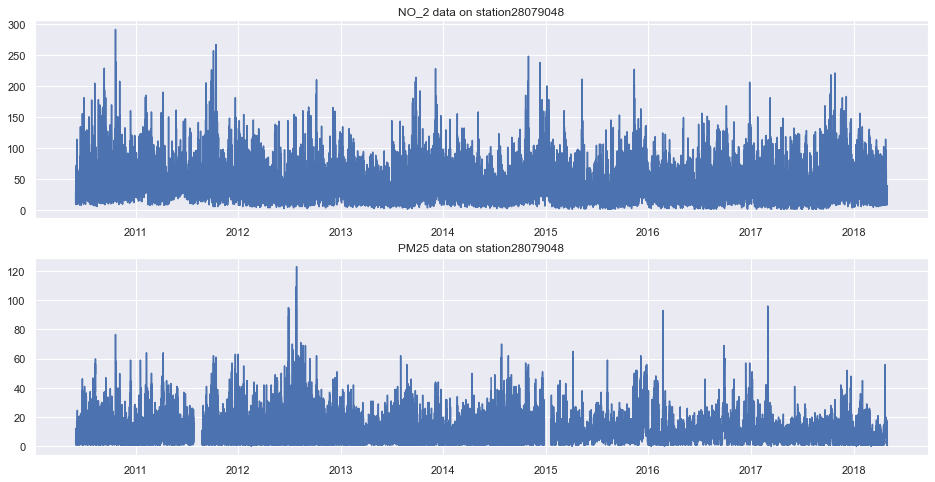

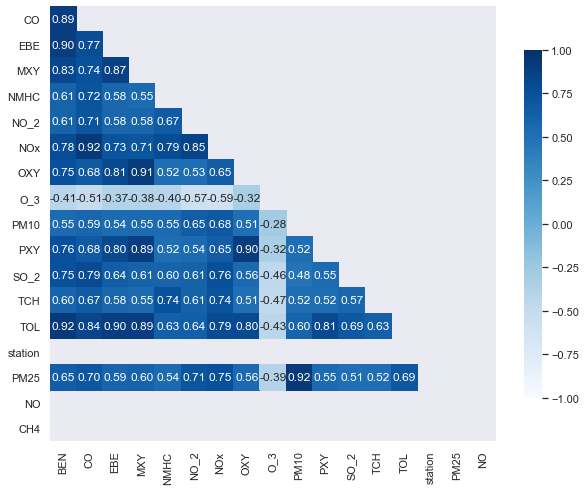

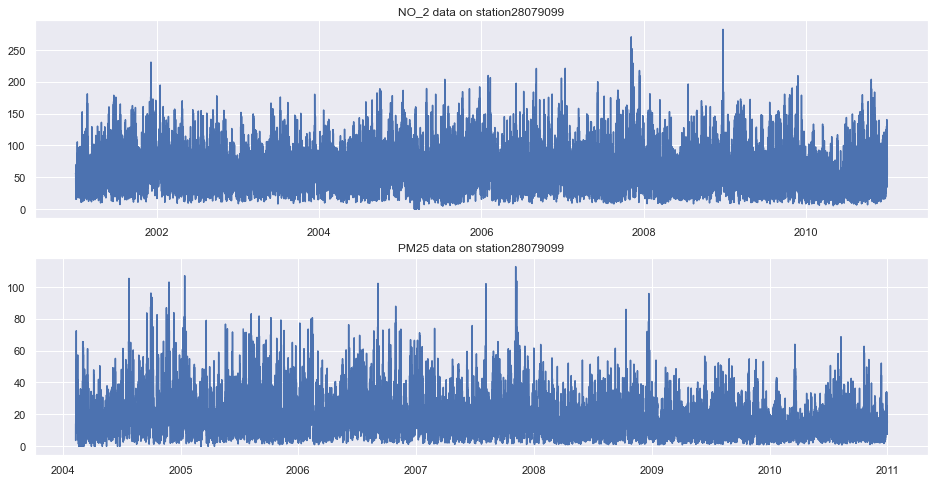

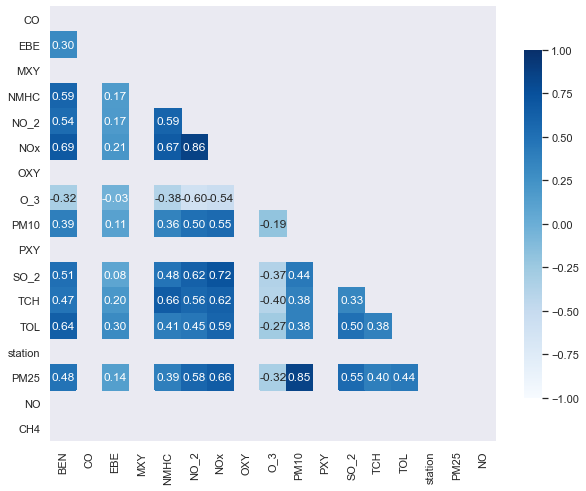

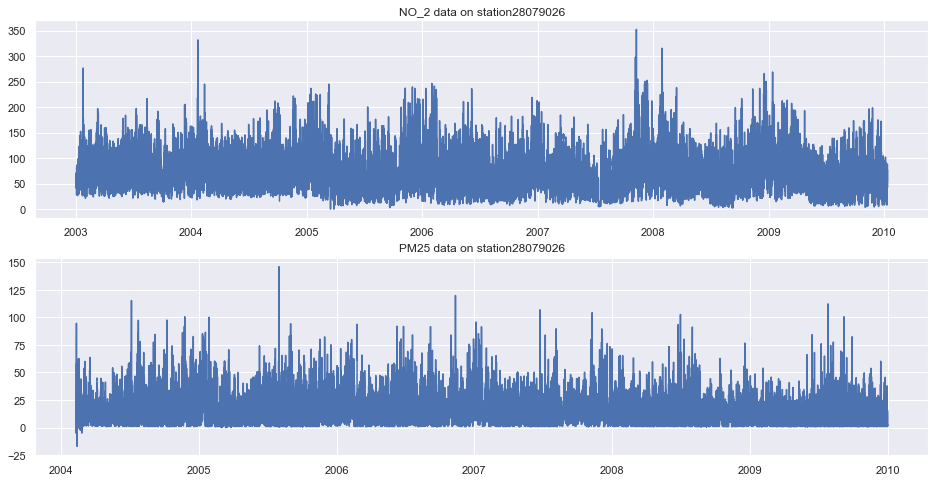

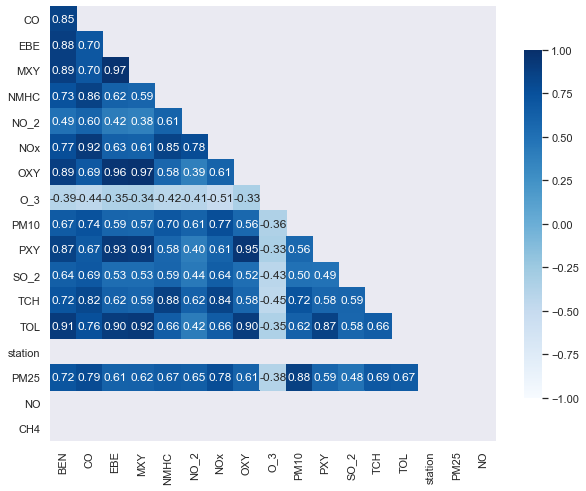

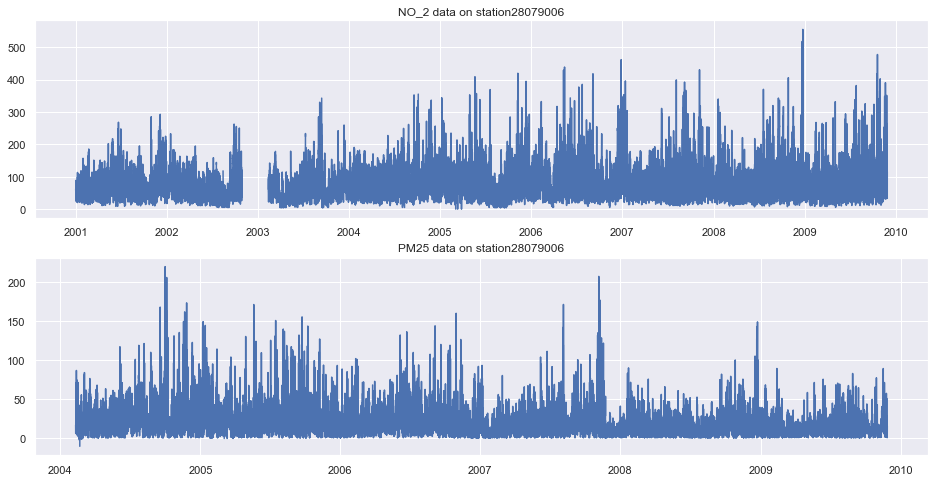

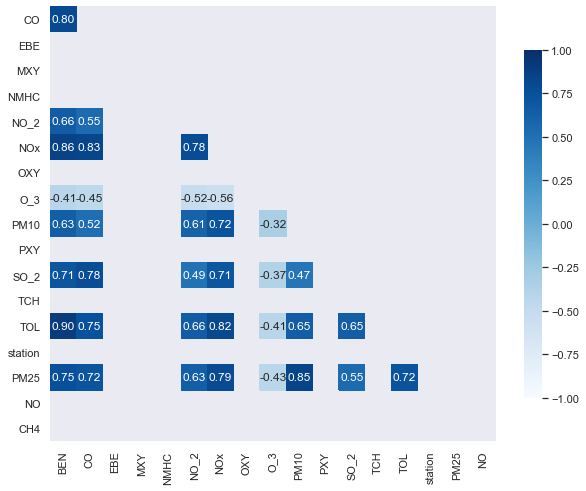

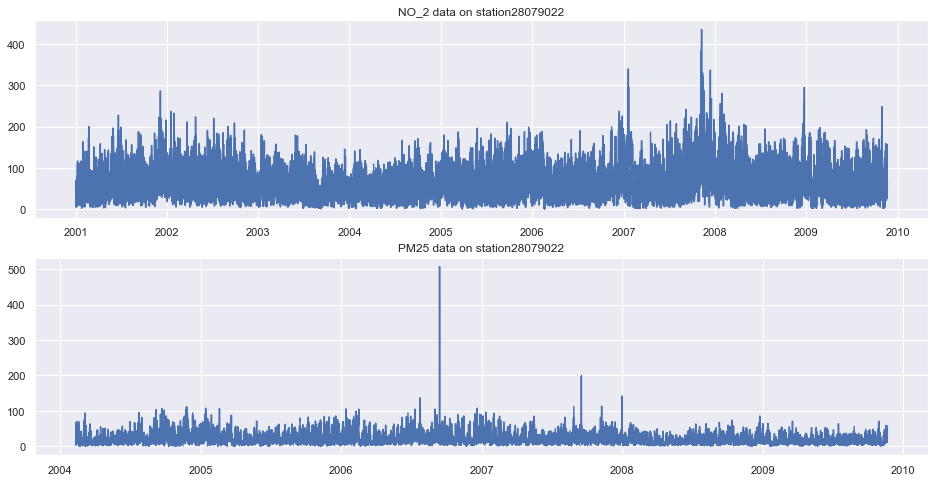

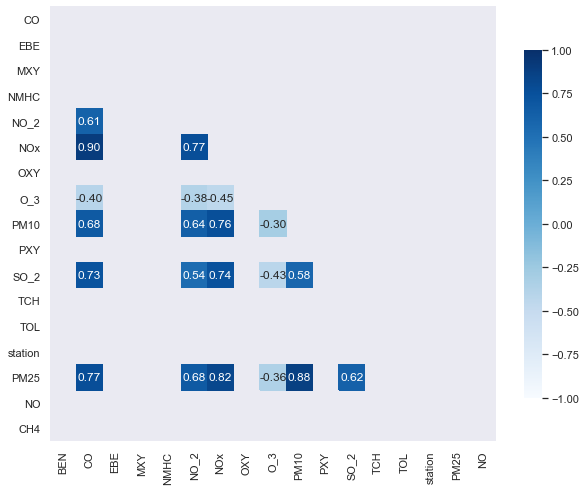

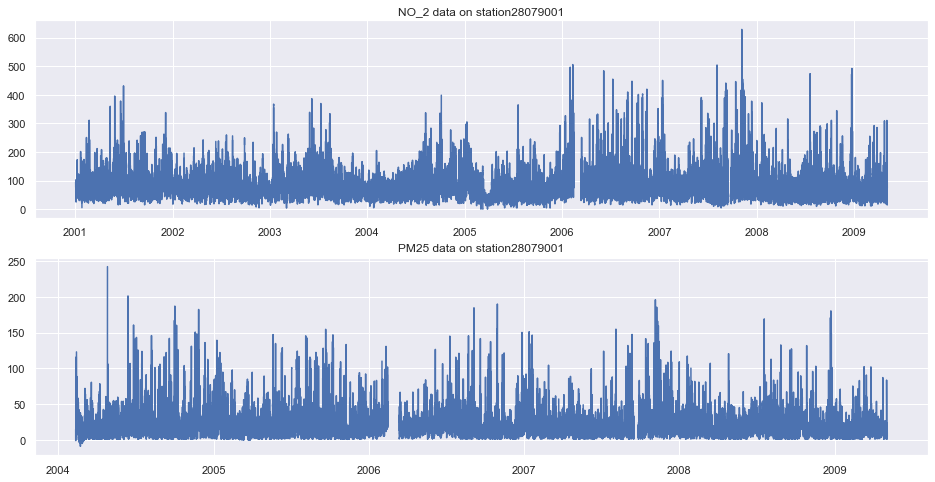

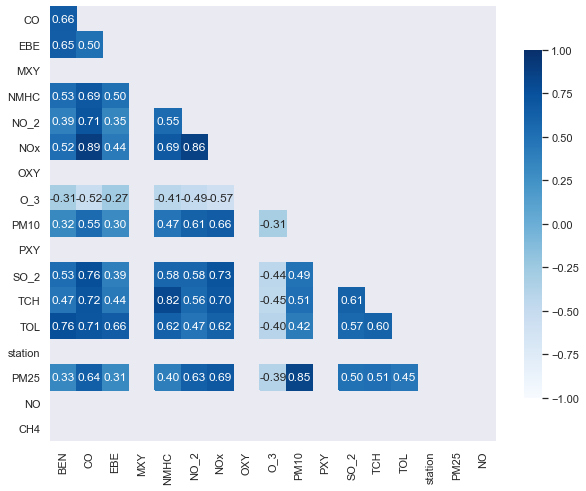

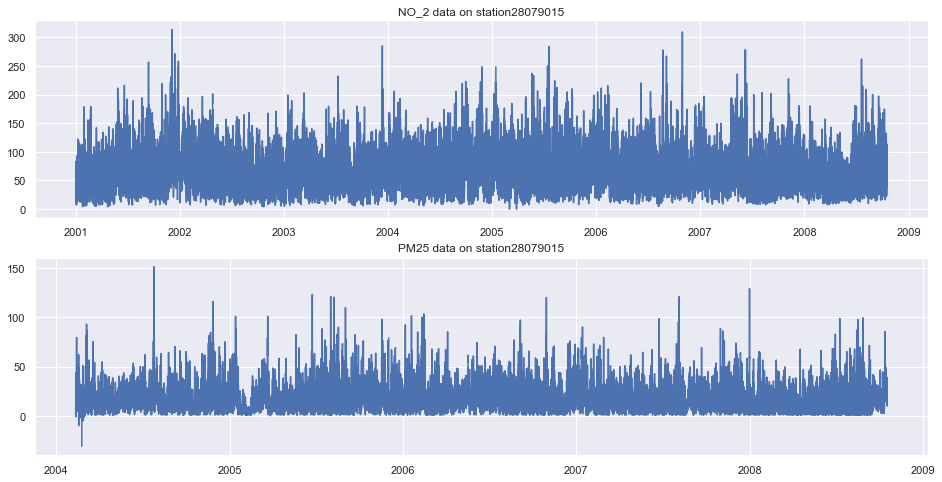

In [3]:
import seaborn as sns; sns.set_theme()

#ids = ['28079024', '28079038', '28079008', '28079047', '28079050', '28079048', '28079048', '28079099', '28079026', '28079006', '28079022', '28079001', '28079015']
ids = [28079024, 28079038, 28079008, 28079047, 28079050, 28079048, 28079099, 28079026, 28079006, 28079022, 28079001, 28079015]

for i in ids:
    dfstation=dffinal[dffinal['station']==i]

    #dfstation.dropna(inplace=True)

    df_corr = dfstation.corr()

    fig, ax = plt.subplots(figsize=(10, 8))
    # mask
    mask = np.triu(np.ones_like(df_corr, dtype=np.bool))
    # adjust mask and df
    mask = mask[1:, :-1]
    corr = df_corr.iloc[1:,:-1].copy()
    # plot heatmap
    sns.heatmap(corr, mask=mask, annot=True, fmt=".2f", cmap='Blues',
           vmin=-1, vmax=1, cbar_kws={"shrink": .8})
    # yticks
    plt.yticks(rotation=0)
    plt.show()

    #dffinal=pd.read_csv("cleaned.csv", index_col='date',parse_dates=True)

#    dffinal_NO2=dffinal.drop(columns=['NO','CH4','BEN','CO','EBE','MXY','NMHC','O_3','NOx','OXY','PM10','PXY','SO_2','TCH','TOL','PM25'])
#    dffinal_PM=dffinal.drop(columns=['NO_2','NO','CH4','BEN','CO','EBE','MXY','NMHC','O_3','NOx','OXY','PM10','PXY','SO_2','TCH','TOL'])
#    print(dffinal_NO2.head())
    
    fig = plt.figure(figsize=(16,8))
    ax1, ax2 = fig.subplots(2,1)
#    afig.suptitle('NO_2 and PM25 data on station '+str(i))
    ax1.set_title('NO_2 data on station'+str(i))
    ax1.plot(dfstation['NO_2'])
    ax2.set_title('PM25 data on station'+str(i))
    ax2.plot(dfstation['PM25'])


In [9]:
#determine contigous intervals on each column

        
def intersections(a,b):
    ranges = []
    i = j = 0
    while i < len(a) and j < len(b):
        a_left, a_right = a[i]
        b_left, b_right = b[j]

        if a_right < b_right:
            i += 1
        else:
            j += 1

        if a_right >= b_left and b_right >= a_left:
            end_pts = sorted([a_left, a_right, b_left, b_right])
            middle = [end_pts[1], end_pts[2]]
            ranges.append(middle)

    ri = 0
    while ri < len(ranges)-1:
        if ranges[ri][1] == ranges[ri+1][0]:
            ranges[ri:ri+2] = [[ranges[ri][0], ranges[ri+1][1]]]

        ri += 1

    return ranges

columns = ['NO_2','PM25']
for i in ids:
    dfstation=dffinal[dffinal['station']==i]
    
    flag = True
    start=dfstation.index[0]
    end=dfstation.index[len(dfstation)-1]
    print("Station "+str(i)+ " data start:"+str(start)+" end:"+str(end))
    ssc = []
    for column in columns:
             
        dfstation.interpolate(method ='time', limit_direction ='forward', limit=48, inplace=True)
        a = dfstation[column].values  # Extract out relevant column from dataframe as array
        m = np.concatenate(( [True], np.isnan(a), [True] ))  # Mask
        ss = np.flatnonzero(m[1:] != m[:-1]).reshape(-1,2)   # Start-stop limits
        ssc.append(ss)
        starti,stopi = ss[(ss[:,1] - ss[:,0]).argmax()]  # Get max interval, interval limits
        
        print("Intervals:"+str(len(ss))+" start:"+str(dfstation.index[starti])+"-"+str(dfstation.index[stopi-1]));
        
    inter = intersections(ssc[0],ssc[1]);
    maxi = [0,0];
    for interval in inter:
        if(abs(maxi[0]-maxi[1])<abs(interval[0]-interval[1])):
            maxi=[interval[0],interval[1]];

    print(i);
    dfstation.drop(dfstation.index[:maxi[0]],inplace=True)
    dfstation.drop(dfstation.index[maxi[1]:],inplace=True)
    dfstation.to_csv('processed-'+str(i)+".csv")


Station 28079024 data start:2001-01-01 01:00:00 end:2018-05-01 00:00:00
Intervals:1 start:2001-01-01 01:00:00-2018-05-01 00:00:00
Intervals:1 start:2004-02-10 13:00:00-2018-03-25 12:00:00
28079024
Station 28079038 data start:2001-01-01 01:00:00 end:2018-05-01 00:00:00
Intervals:2 start:2008-12-09 09:00:00-2018-05-01 00:00:00
Intervals:3 start:2007-01-24 16:00:00-2015-01-03 15:00:00
28079038
Station 28079008 data start:2001-01-01 01:00:00 end:2018-05-01 00:00:00
Intervals:2 start:2007-06-06 15:00:00-2018-05-01 00:00:00
Intervals:5 start:2011-10-24 10:00:00-2015-01-30 11:00:00
28079008
Station 28079047 data start:2009-12-21 01:00:00 end:2018-05-01 00:00:00
Intervals:1 start:2009-12-21 01:00:00-2018-05-01 00:00:00
Intervals:2 start:2009-12-21 01:00:00-2015-01-11 10:00:00
28079047
Station 28079050 data start:2010-02-04 01:00:00 end:2018-05-01 00:00:00
Intervals:1 start:2010-02-08 01:00:00-2018-05-01 00:00:00
Intervals:4 start:2010-02-08 01:00:00-2015-01-03 10:00:00
28079050
Station 2807904

28079024
                      BEN    CO   EBE   MXY  NMHC       NO_2        NOx   OXY  \
date                                                                            
2004-02-10 13:00:00  1.82  0.42  2.12  4.28  0.10  38.090000  50.799999  2.26   
2004-02-10 14:00:00  1.15  0.36  1.58  3.16  0.10  34.840000  45.700001  1.64   
2004-02-10 15:00:00  0.84  0.34  1.21  2.17  0.09  27.780001  35.049999  1.06   
2004-02-10 16:00:00  0.68  0.28  0.93  1.71  0.08  21.320000  25.719999  0.83   
2004-02-10 17:00:00  0.47  0.27  0.48  0.80  0.08  26.180000  30.850000  0.52   

                           O_3       PM10   PXY   SO_2   TCH   TOL   station  \
date                                                                           
2004-02-10 13:00:00  49.990002  31.170000  1.80  14.16  1.28  8.21  28079024   
2004-02-10 14:00:00  55.259998  28.690001  1.28  12.37  1.28  5.62  28079024   
2004-02-10 15:00:00  63.419998  24.000000  0.86   9.50  1.27  4.75  28079024   
2004-02-10 16:00:00  70

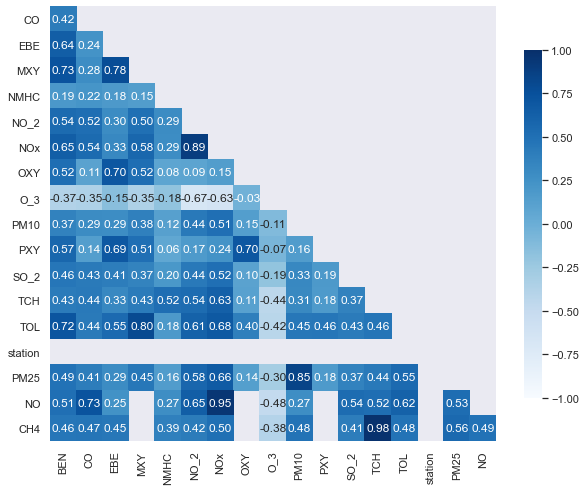

28079038
                     BEN    CO  EBE  MXY  NMHC       NO_2         NOx  OXY  \
date                                                                         
2008-12-09 09:00:00  NaN  0.55  NaN  NaN   NaN  69.779999  149.000000  NaN   
2008-12-09 10:00:00  NaN  0.73  NaN  NaN   NaN  78.199997  190.399994  NaN   
2008-12-09 11:00:00  NaN  0.45  NaN  NaN   NaN  60.700001  112.099998  NaN   
2008-12-09 12:00:00  NaN  0.49  NaN  NaN   NaN  65.570000  134.399994  NaN   
2008-12-09 13:00:00  NaN  0.47  NaN  NaN   NaN  74.040001  141.500000  NaN   

                           O_3       PM10  PXY       SO_2  TCH  TOL   station  \
date                                                                            
2008-12-09 09:00:00   9.820000  25.030001  NaN  14.690000  NaN  NaN  28079038   
2008-12-09 10:00:00   8.860000  35.610001  NaN  16.709999  NaN  NaN  28079038   
2008-12-09 11:00:00  17.510000   4.570000  NaN  14.470000  NaN  NaN  28079038   
2008-12-09 12:00:00  17.629999  18.6399

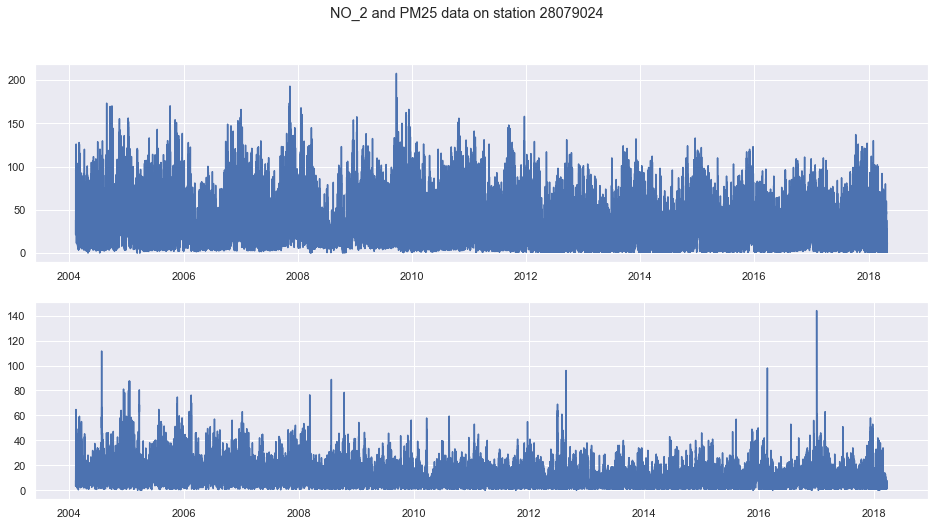

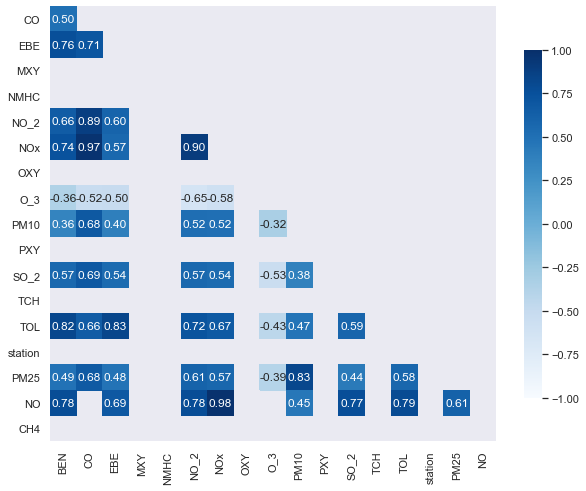

28079008
                     BEN   CO  EBE  MXY   NMHC  NO_2  NOx  OXY   O_3  PM10  \
date                                                                         
2011-10-24 10:00:00  0.8  0.2  1.3  NaN  0.135  35.0  NaN  NaN  16.0  23.0   
2011-10-24 11:00:00  0.7  0.2  1.7  NaN  0.140  46.0  NaN  NaN  22.0  18.0   
2011-10-24 12:00:00  0.7  0.1  1.4  NaN  0.110  43.0  NaN  NaN  24.0  18.0   
2011-10-24 13:00:00  0.6  0.2  2.1  NaN  0.130  50.0  NaN  NaN  20.0  19.0   
2011-10-24 14:00:00  0.8  0.2  2.2  NaN  0.130  53.0  NaN  NaN  19.0  21.0   

                     PXY  SO_2    TCH  TOL   station  PM25    NO  CH4  
date                                                                   
2011-10-24 10:00:00  NaN   4.0  1.395  3.2  28079008   3.0  20.0  NaN  
2011-10-24 11:00:00  NaN   4.0  1.410  2.9  28079008   9.0  24.0  NaN  
2011-10-24 12:00:00  NaN   4.0  1.270  3.4  28079008  10.0  23.0  NaN  
2011-10-24 13:00:00  NaN   4.0  1.270  4.3  28079008  12.0  32.0  NaN  
2011-10-24 1

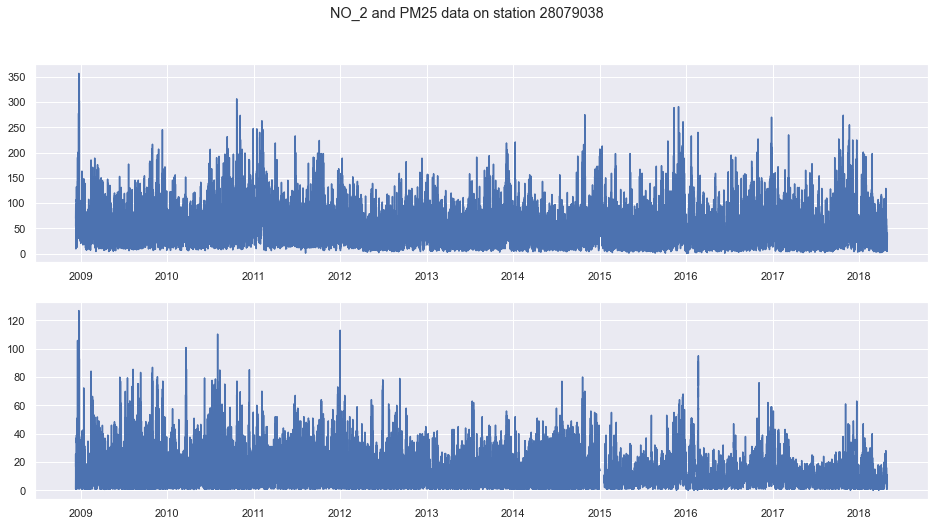

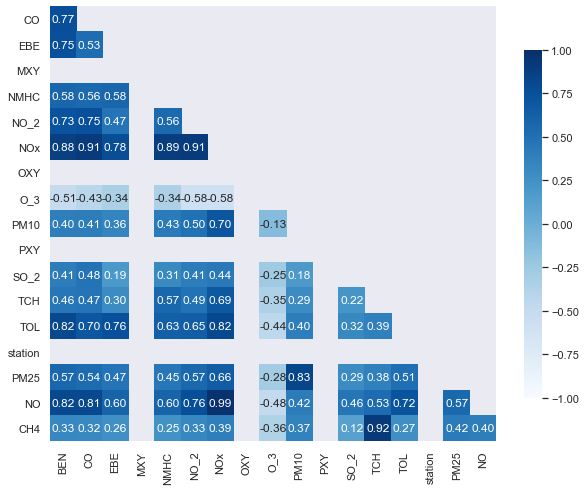

28079047
                     BEN  CO  EBE  MXY  NMHC       NO_2         NOx  OXY  O_3  \
date                                                                            
2009-12-21 01:00:00  NaN NaN  NaN  NaN   NaN  93.470001  217.100006  NaN  NaN   
2009-12-21 02:00:00  NaN NaN  NaN  NaN   NaN  66.309998   93.290001  NaN  NaN   
2009-12-21 03:00:00  NaN NaN  NaN  NaN   NaN  63.610001   75.139999  NaN  NaN   
2009-12-21 04:00:00  NaN NaN  NaN  NaN   NaN  46.360001   49.040001  NaN  NaN   
2009-12-21 05:00:00  NaN NaN  NaN  NaN   NaN  36.349998   38.049999  NaN  NaN   

                          PM10  PXY  SO_2  TCH  TOL   station   PM25  NO  CH4  
date                                                                           
2009-12-21 01:00:00  43.580002  NaN   NaN  NaN  NaN  28079047  24.01 NaN  NaN  
2009-12-21 02:00:00  12.060000  NaN   NaN  NaN  NaN  28079047   5.28 NaN  NaN  
2009-12-21 03:00:00  23.309999  NaN   NaN  NaN  NaN  28079047  11.09 NaN  NaN  
2009-12-21 04:00:00  10

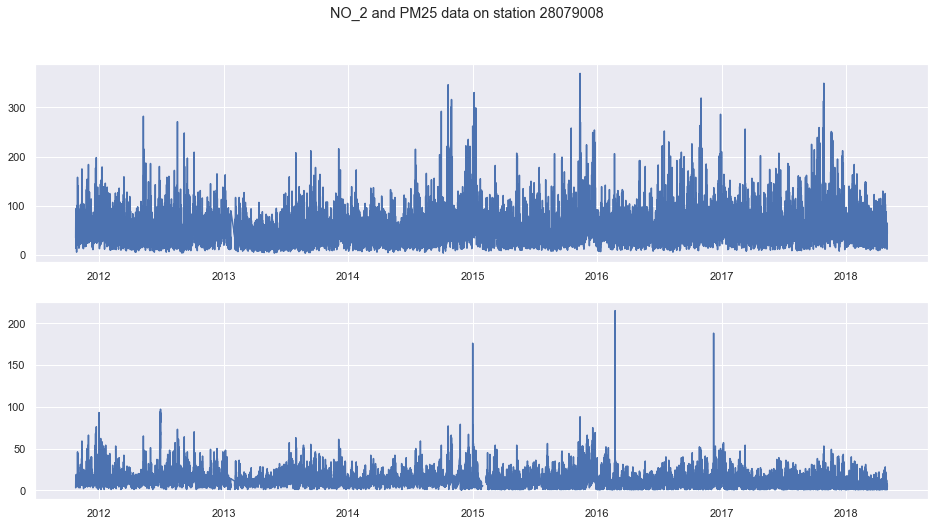

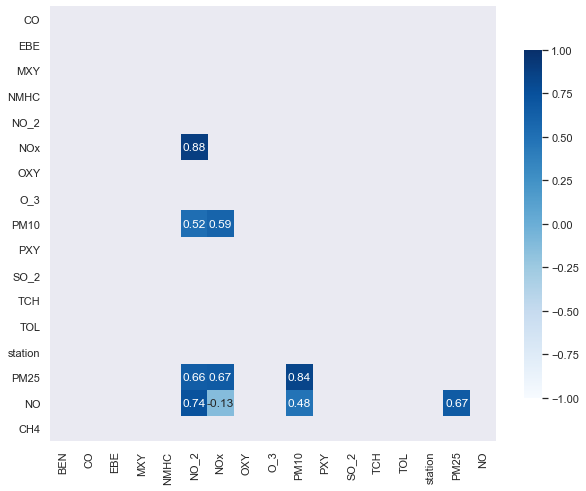

28079050
                     BEN  CO  EBE  MXY  NMHC       NO_2        NOx  OXY  O_3  \
date                                                                           
2010-02-08 01:00:00  NaN NaN  NaN  NaN   NaN  52.209999  71.860001  NaN  NaN   
2010-02-08 02:00:00  NaN NaN  NaN  NaN   NaN  39.220001  55.169998  NaN  NaN   
2010-02-08 03:00:00  NaN NaN  NaN  NaN   NaN  23.020000  31.740000  NaN  NaN   
2010-02-08 04:00:00  NaN NaN  NaN  NaN   NaN  21.340000  29.219999  NaN  NaN   
2010-02-08 05:00:00  NaN NaN  NaN  NaN   NaN  28.110001  37.509998  NaN  NaN   

                          PM10  PXY  SO_2  TCH  TOL   station   PM25  NO  CH4  
date                                                                           
2010-02-08 01:00:00  19.639999  NaN   NaN  NaN  NaN  28079050  14.65 NaN  NaN  
2010-02-08 02:00:00  14.230000  NaN   NaN  NaN  NaN  28079050  13.05 NaN  NaN  
2010-02-08 03:00:00  10.030000  NaN   NaN  NaN  NaN  28079050  10.27 NaN  NaN  
2010-02-08 04:00:00   9.490000

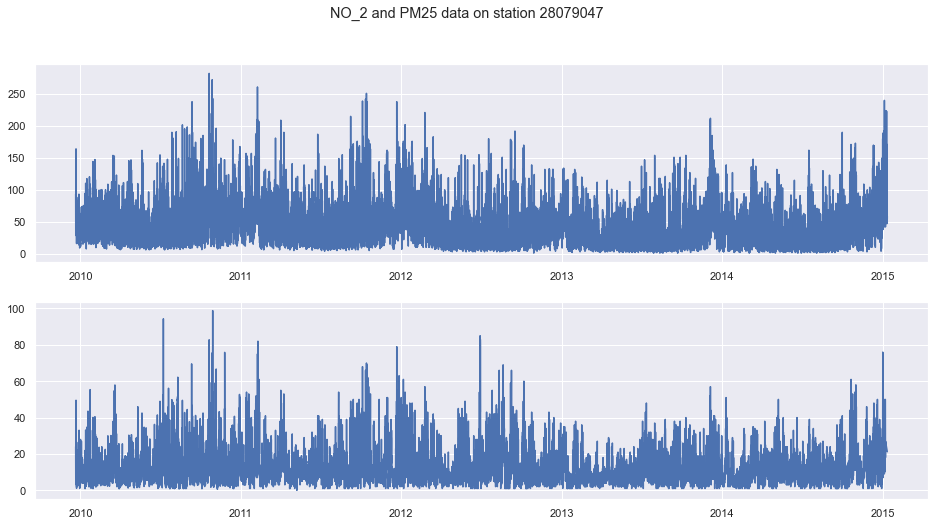

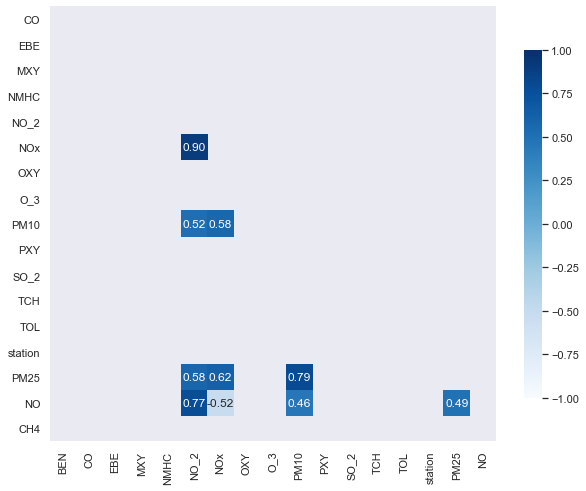

28079048
                     BEN  CO  EBE  MXY  NMHC  NO_2  NOx  OXY  O_3  PM10  PXY  \
date                                                                           
2011-08-25 14:00:00  NaN NaN  NaN  NaN   NaN  30.0  NaN  NaN  NaN   5.0  NaN   
2011-08-25 15:00:00  NaN NaN  NaN  NaN   NaN  28.0  NaN  NaN  NaN   5.0  NaN   
2011-08-25 16:00:00  NaN NaN  NaN  NaN   NaN  27.0  NaN  NaN  NaN   5.0  NaN   
2011-08-25 17:00:00  NaN NaN  NaN  NaN   NaN  23.0  NaN  NaN  NaN   4.0  NaN   
2011-08-25 18:00:00  NaN NaN  NaN  NaN   NaN  24.0  NaN  NaN  NaN   5.0  NaN   

                     SO_2  TCH  TOL   station  PM25   NO  CH4  
date                                                           
2011-08-25 14:00:00   NaN  NaN  NaN  28079048   1.0  5.0  NaN  
2011-08-25 15:00:00   NaN  NaN  NaN  28079048   1.0  5.0  NaN  
2011-08-25 16:00:00   NaN  NaN  NaN  28079048   1.0  5.0  NaN  
2011-08-25 17:00:00   NaN  NaN  NaN  28079048   1.0  6.0  NaN  
2011-08-25 18:00:00   NaN  NaN  NaN  28079048 

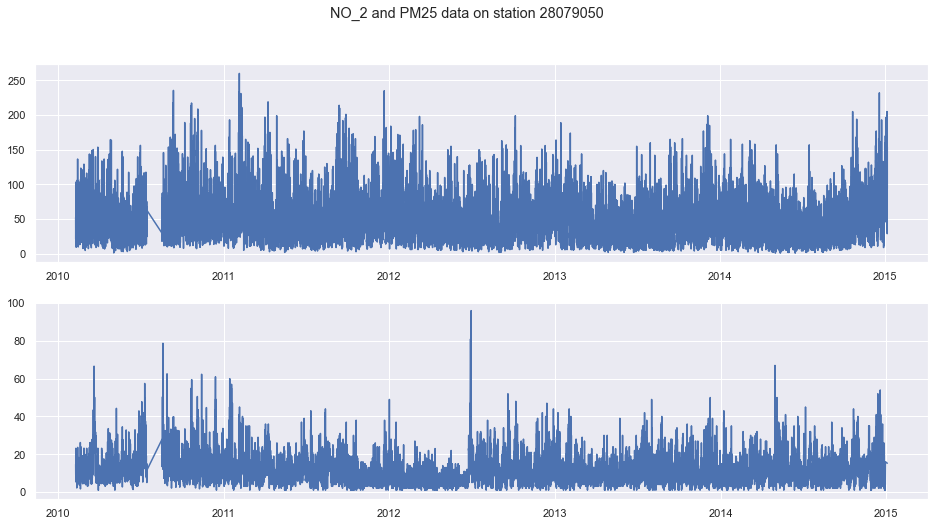

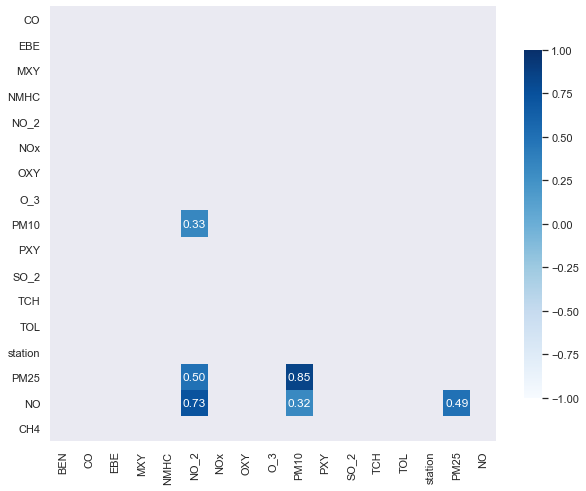

28079099
                      BEN    CO   EBE   MXY  NMHC       NO_2         NOx  \
date                                                                       
2004-02-10 13:00:00  1.79  0.66  2.96  7.65  0.19  65.419998  126.000000   
2004-02-10 14:00:00  1.44  0.55  2.61  6.47  0.18  58.820000  105.000000   
2004-02-10 15:00:00  1.59  0.50  2.71  6.20  0.18  49.630001   85.029999   
2004-02-10 16:00:00  1.37  0.43  2.19  5.40  0.14  47.270000   76.550003   
2004-02-10 17:00:00  0.99  0.47  1.61  3.96  0.16  55.419998   90.260002   

                      OXY        O_3       PM10   PXY       SO_2   TCH  \
date                                                                     
2004-02-10 13:00:00  4.03  25.389999  50.779999  3.09  20.389999  1.39   
2004-02-10 14:00:00  3.47  34.680000  30.200001  2.62  16.969999  1.37   
2004-02-10 15:00:00  3.23  45.209999  16.549999  2.49  14.330000  1.35   
2004-02-10 16:00:00  3.00  48.509998  21.570000  2.24  13.640000  1.32   
2004-02-10 17:

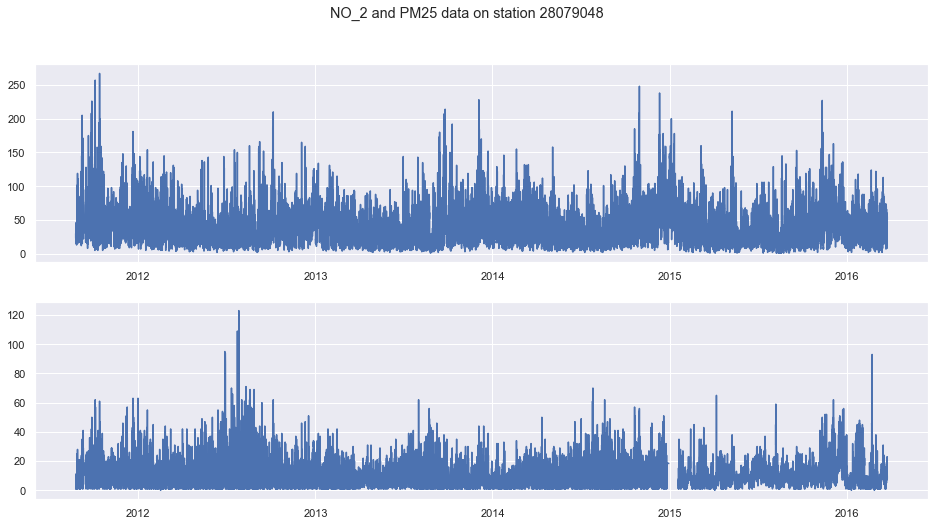

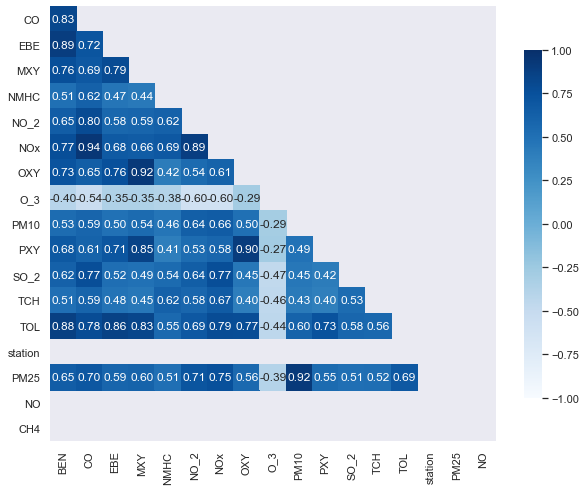

28079026
                     BEN  CO  EBE  MXY  NMHC       NO_2    NOx  OXY  \
date                                                                  
2004-02-10 13:00:00  NaN NaN  NaN  NaN  0.15  92.320000  176.0  NaN   
2004-02-10 14:00:00  NaN NaN  NaN  NaN  0.09  71.830002  122.0  NaN   
2004-02-10 15:00:00  NaN NaN  NaN  NaN  0.10  74.949997  126.0  NaN   
2004-02-10 16:00:00  NaN NaN  NaN  NaN  0.09  87.000000  157.0  NaN   
2004-02-10 17:00:00  NaN NaN  NaN  NaN  0.08  80.269997  130.0  NaN   

                           O_3       PM10  PXY   SO_2   TCH  TOL   station  \
date                                                                         
2004-02-10 13:00:00  18.940001  99.480003  NaN  14.55  1.51  NaN  28079026   
2004-02-10 14:00:00  36.049999  10.900000  NaN  11.00  1.43  NaN  28079026   
2004-02-10 15:00:00  39.849998   7.290000  NaN   9.91  1.43  NaN  28079026   
2004-02-10 16:00:00  35.889999  33.189999  NaN   9.94  1.41  NaN  28079026   
2004-02-10 17:00:00  37.9

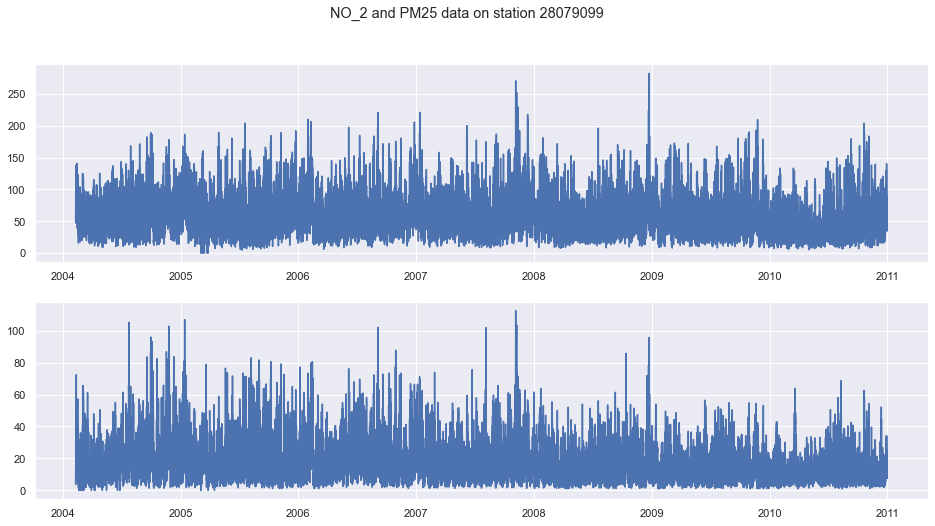

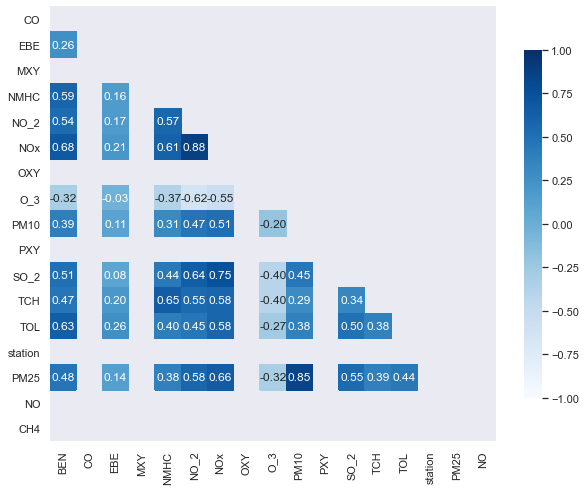

28079006
                      BEN    CO   EBE    MXY  NMHC       NO_2    NOx   OXY  \
date                                                                         
2004-02-10 13:00:00  4.34  0.98  5.86  13.42  0.25  75.580002  189.0  6.53   
2004-02-10 14:00:00  3.83  1.18  5.37  12.11  0.31  83.769997  231.0  6.00   
2004-02-10 15:00:00  4.43  0.94  5.73  12.56  0.21  73.730003  180.0  6.07   
2004-02-10 16:00:00  2.79  0.62  4.20   9.71  0.14  69.019997  139.0  4.79   
2004-02-10 17:00:00  2.10  0.82  3.09   7.05  0.20  80.169998  176.0  3.57   

                           O_3       PM10   PXY       SO_2   TCH        TOL  \
date                                                                          
2004-02-10 13:00:00  16.719999  40.799999  5.31  18.410000  1.44  22.110001   
2004-02-10 14:00:00  17.420000  26.920000  4.83  19.820000  1.51  20.510000   
2004-02-10 15:00:00  24.930000  20.030001  4.97  18.520000  1.41  23.080000   
2004-02-10 16:00:00  29.639999  21.670000  3.93  

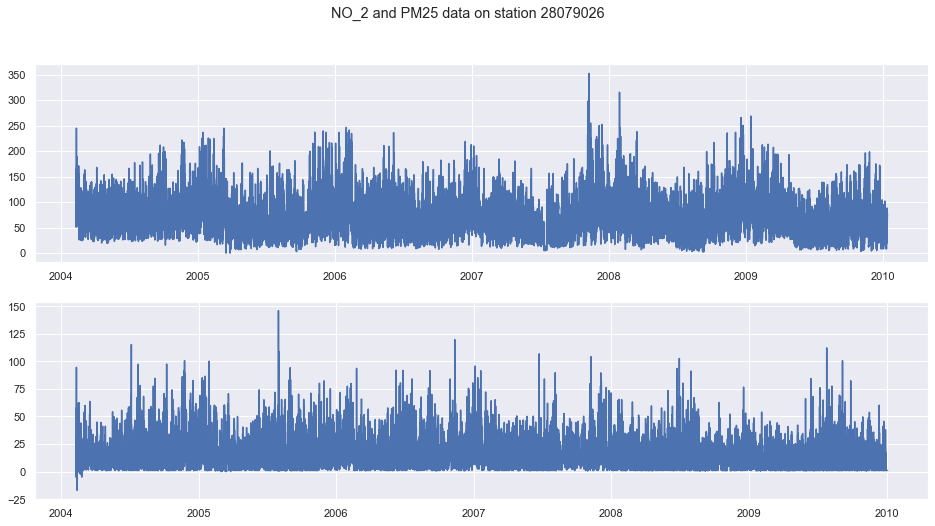

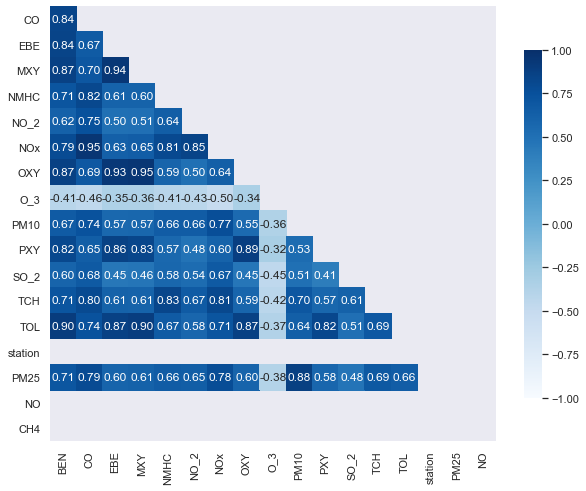

28079022
                      BEN    CO  EBE  MXY  NMHC       NO_2         NOx  OXY  \
date                                                                          
2004-02-10 13:00:00  1.39  0.57  NaN  NaN   NaN  60.630001  127.000000  NaN   
2004-02-10 14:00:00  1.01  0.39  NaN  NaN   NaN  54.810001  107.000000  NaN   
2004-02-10 15:00:00  0.53  0.39  NaN  NaN   NaN  46.860001   86.730003  NaN   
2004-02-10 16:00:00  0.96  0.37  NaN  NaN   NaN  50.040001   92.419998  NaN   
2004-02-10 17:00:00  0.67  0.41  NaN  NaN   NaN  57.869999  108.000000  NaN   

                           O_3       PM10  PXY   SO_2  TCH     TOL   station  \
date                                                                           
2004-02-10 13:00:00  19.840000  36.150002  NaN  20.67  NaN   9.090  28079022   
2004-02-10 14:00:00  25.639999  41.259998  NaN  14.63  NaN  15.930  28079022   
2004-02-10 15:00:00  35.000000  17.040001  NaN  12.87  NaN  14.565  28079022   
2004-02-10 16:00:00  33.380001  23.41

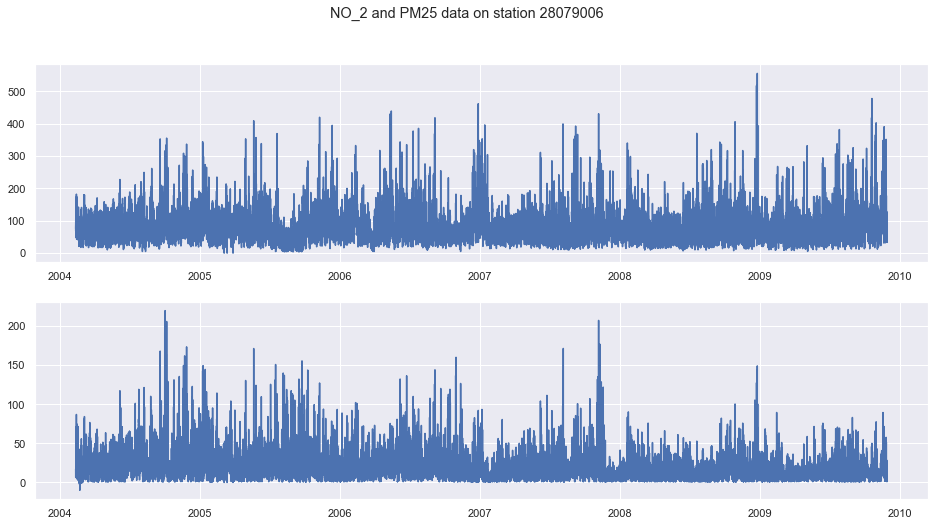

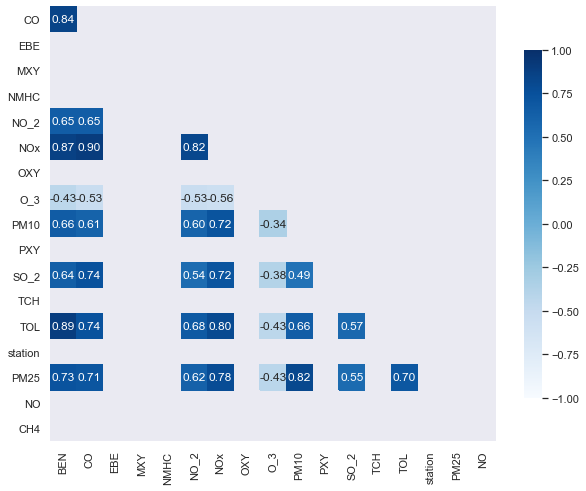

28079001
                     BEN    CO  EBE  MXY  NMHC       NO_2        NOx  OXY  \
date                                                                        
2006-03-13 01:00:00  NaN  0.43  NaN  NaN   NaN  54.980000  75.860001  NaN   
2006-03-13 02:00:00  NaN  0.31  NaN  NaN   NaN  46.459999  59.630001  NaN   
2006-03-13 03:00:00  NaN  0.28  NaN  NaN   NaN  37.740002  48.500000  NaN   
2006-03-13 04:00:00  NaN  0.27  NaN  NaN   NaN  30.000000  37.459999  NaN   
2006-03-13 05:00:00  NaN  0.29  NaN  NaN   NaN  30.150000  35.700001  NaN   

                           O_3   PM10  PXY  SO_2  TCH  TOL   station  PM25  \
date                                                                         
2006-03-13 01:00:00  18.190001  11.07  NaN  9.56  NaN  NaN  28079001  2.82   
2006-03-13 02:00:00  22.150000   7.25  NaN  7.86  NaN  NaN  28079001  1.42   
2006-03-13 03:00:00  24.520000   7.98  NaN  7.38  NaN  NaN  28079001  1.35   
2006-03-13 04:00:00  28.160000   2.93  NaN  6.76  NaN  NaN  2

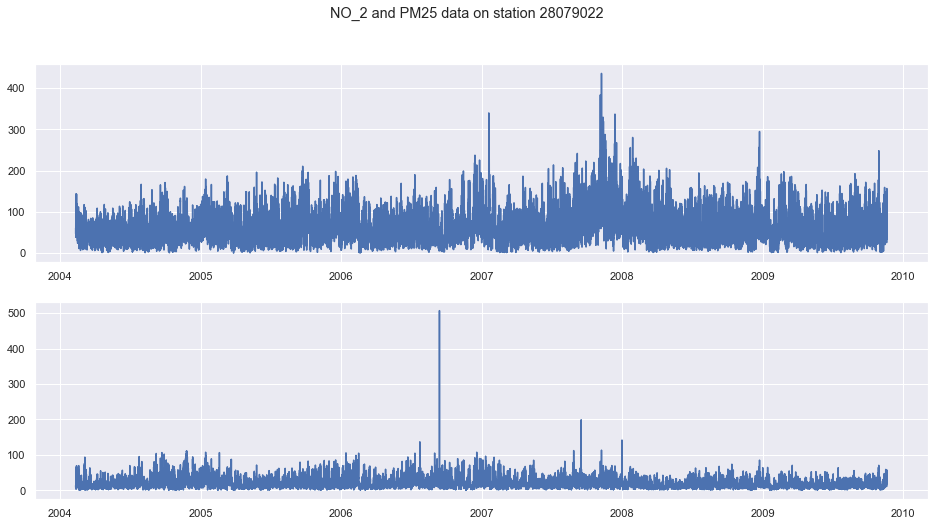

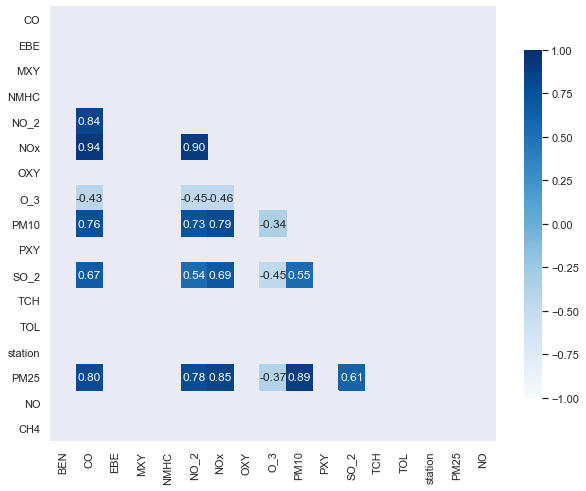

28079015
                      BEN    CO   EBE  MXY  NMHC       NO_2    NOx  OXY  \
date                                                                      
2004-02-10 13:00:00  1.39  0.64  2.54  NaN  0.20  73.739998  155.0  NaN   
2004-02-10 14:00:00  1.46  0.66  2.33  NaN  0.21  76.529999  154.0  NaN   
2004-02-10 15:00:00  2.17  0.75  2.76  NaN  0.21  78.089996  162.0  NaN   
2004-02-10 16:00:00  1.59  0.52  2.08  NaN  0.17  62.310001  112.0  NaN   
2004-02-10 17:00:00  1.08  0.66  1.76  NaN  0.20  79.089996  153.0  NaN   

                           O_3       PM10  PXY       SO_2   TCH    TOL  \
date                                                                     
2004-02-10 13:00:00  22.770000  50.930000  NaN  16.950001  1.36  10.93   
2004-02-10 14:00:00  27.920000  24.170000  NaN  15.090000  1.35  12.50   
2004-02-10 15:00:00  30.260000  25.389999  NaN  16.330000  1.36  12.72   
2004-02-10 16:00:00  41.599998  13.950000  NaN  13.200000  1.31   7.50   
2004-02-10 17:00:00  

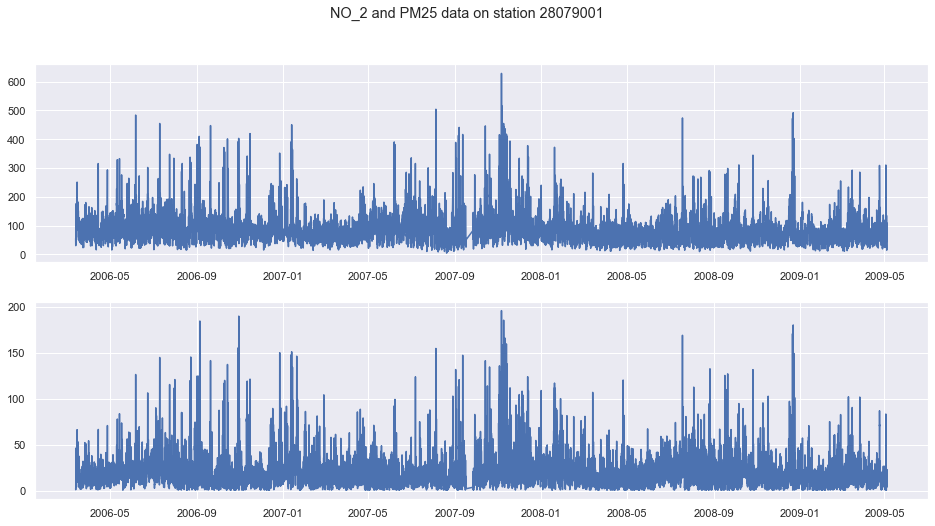

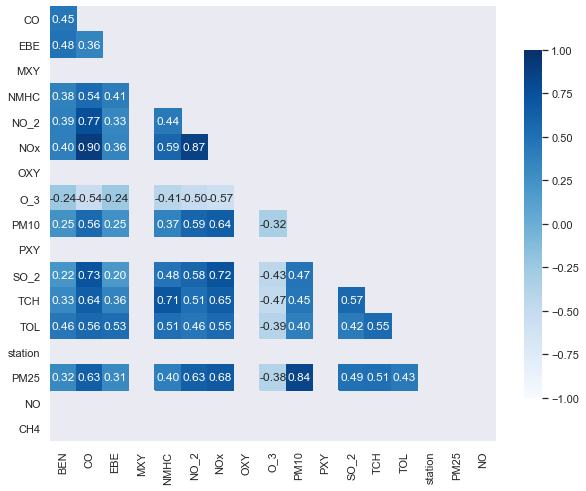

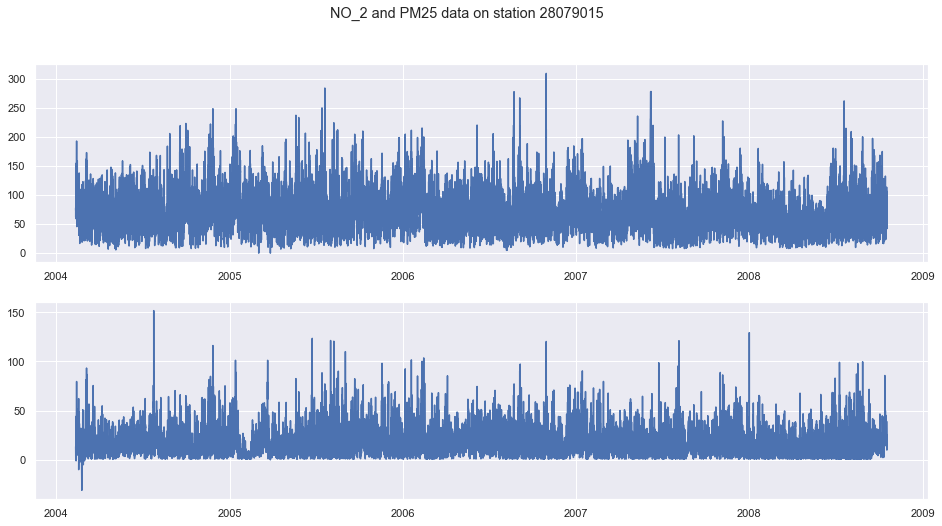

In [10]:
for i in ids:
    print(str(i))
    dfstation=pd.read_csv("processed-"+str(i)+".csv", index_col='date', parse_dates=True)
    print(dfstation.head())

    df_corr = dfstation.corr()

    fig, ax = plt.subplots(figsize=(10, 8))
    # mask
    mask = np.triu(np.ones_like(df_corr, dtype=np.bool))
    # adjust mask and df
    mask = mask[1:, :-1]
    corr = df_corr.iloc[1:,:-1].copy()
    # plot heatmap
    sns.heatmap(corr, mask=mask, annot=True, fmt=".2f", cmap='Blues',
                vmin=-1, vmax=1, cbar_kws={"shrink": .8})
    # yticks
    plt.yticks(rotation=0)
    plt.show()
    
    fig = plt.figure(figsize=(16,8))
    ax1, ax2 = fig.subplots(2,1)
    fig.suptitle('NO_2 and PM25 data on station '+str(i))
    ax1.plot(dfstation['NO_2'])
    ax2.plot(dfstation['PM25'])